In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut   
from qiskit.aqua.algorithms import VQE         
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely


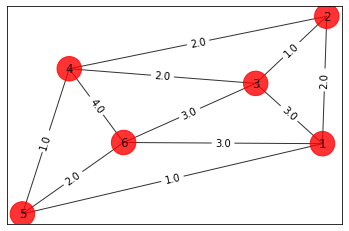

In [2]:
# Number of nodes in graph
n=6 
G=nx.Graph()
G.add_nodes_from(np.arange(1,n,1))
elist=[(1,2,2.0),(2,3,1.0),(3,4,2.0),(4,5,1.0),(5,6,2.0),(6,1,3.0),(1,3,3.0),(1,5,1.0),(2,4,2.0),(3,6,3.0),(4,6,4.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [3]:
pos

{1: array([ 0.56810463, -0.31479524]),
 2: array([0.58603913, 0.92842124]),
 3: array([0.28864074, 0.27342078]),
 4: array([-0.49138405,  0.41613601]),
 5: array([-0.68739831, -1.        ]),
 6: array([-0.26400214, -0.30318279])}

In [4]:
colors

['r', 'r', 'r', 'r', 'r', 'r']

In [5]:
G

In [6]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 3. 0. 1.]
 [0. 2. 0. 1. 2. 0.]
 [0. 3. 1. 0. 2. 0.]
 [0. 0. 2. 2. 0. 1.]
 [0. 1. 0. 0. 1. 0.]]


In [7]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -6.0
Ising Hamiltonian:
IIIZZI	(1+0j)
IIZIZI	(1.5+0j)
IIZZII	(0.5+0j)
IZIZII	(1+0j)
IZZIII	(1+0j)
ZIIIZI	(0.5+0j)
ZZIIII	(0.5+0j)



In [8]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [9]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)


In [10]:
result = vqe.run(quantum_instance)


In [11]:
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: -4.965511711953637
time: 13.42952585220337
max-cut objective: -10.965511711953637
solution: [0. 1. 0. 0. 1. 0.]
solution objective: 11.0


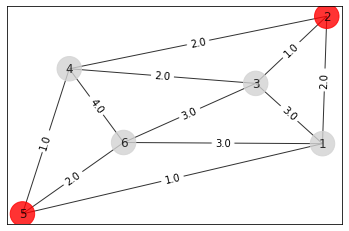

In [18]:
colors = ['lightgrey' if max_cut.get_graph_solution(x)[i] == 0 else 'r' for i in range(n)]
draw_graph(G, colors, pos)